In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from scipy.stats import norm, spearmanr, kendalltau
import sys

# Get the absolute path of the current notebook
sys.path.append('../old_model_generator')
sys.path.append('../ebm')

#from ..model_generator.model_factory import ModelFactory
from old_model_generator.canonical_generator import CanonicalGenerator
from old_model_generator.sample_generator import SampleGenerator

from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities



In [58]:
def run_ebm(X, y, prior = None, random_state = 1):
    
    log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)
    
    rng = np.random.RandomState(random_state)
    ideal_order = np.arange(X.shape[1])
    # ditching np.shuffle due to lack of ability to assign randomized starting-order to variable
    starting_order = rng.choice(ideal_order, len(ideal_order), replace=False)
    starting_order_copy = starting_order.copy()
     
    order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                                n_iter=10_000, order = starting_order,
                                                prior=prior,
                                                random_state=random_state)
    
    greedy_loglike = loglike
    greedy_order = order.copy()
    orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 prior = prior,
                                                 random_state=random_state)
    
    if len(orders) != 0:
        best_order_idx = np.argmax(loglike)
        best_order = orders[best_order_idx]
        best_order = best_order.copy()
    if len(orders) == 0:
        print("Warning: MCMC did not accept new orders, returning greedy ascent result.")
        best_order = order
    
    ## statistical calculations
    
    starting_spearmanr, _ = spearmanr(ideal_order, starting_order_copy)
    greedy_spearmanr, _ = spearmanr(ideal_order, greedy_order)
    best_spearmanr, _ = spearmanr(ideal_order, best_order)

    starting_kendalltau, _ = kendalltau(ideal_order, starting_order_copy)
    greedy_kendalltau, _ = kendalltau(ideal_order, greedy_order)
    best_kendalltau, _ = kendalltau(ideal_order, best_order)
    
    ## results dict
    
    results = {
        'starting_order': starting_order_copy,
        'greedy_order': greedy_order,
        'best_order': best_order,
        'starting_spearmanr': starting_spearmanr,
        'greedy_spearmanr': greedy_spearmanr,
        'best_spearmanr': best_spearmanr,        
        'starting_kendalltau': starting_kendalltau,
        'greedy_kendalltau': greedy_kendalltau,
        'best_kendalltau': best_kendalltau
    }
    
    return results

In [59]:
def run_multiple_ebm(X, y, prior = None, n_trials = 10, csv_filename = 'name.csv'):
    results_list = []

    for trial in range(n_trials):
        result = run_ebm(X, y, prior, random_state=trial)
        results_list.append({
            'run': trial,
            'starting_order': result['starting_order'].tolist(),
            'greedy_order': result['greedy_order'].tolist(),
            'best_order': result['best_order'].tolist(),
            'starting_spearmanr': result['starting_spearmanr'],
            'greedy_spearmanr': result['greedy_spearmanr'],
            'best_spearmanr': result['best_spearmanr'],
            'starting_kendalltau': result['starting_kendalltau'],
            'greedy_kendalltau': result['greedy_kendalltau'],
            'best_kendalltau': result['best_kendalltau']
        })
    
    df = pd.DataFrame(results_list)
    df.to_csv(csv_filename, index=False)
    return df

# Example of how to use the function (assuming X and y are defined):
# run_multiple_ebm(X, y, 100, 'ebm_results.csv')


### `sigmoid`

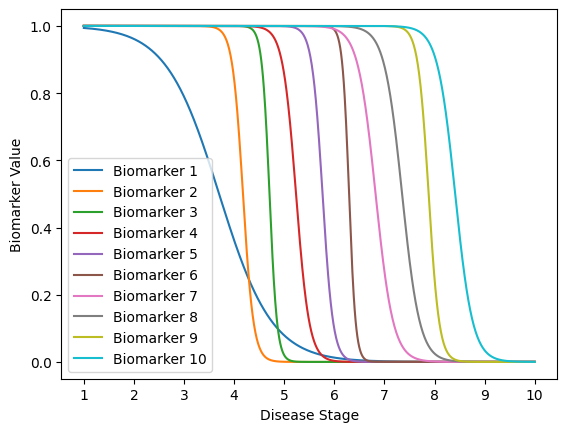

In [62]:
model_type = 'inverse_sigmoid'
params = {
    0: {'s': 0.1, 'c': 1.0},
    1: {'s': 0.5, 'c': 10.0},
    2: {'s': 0.7, 'c': 20.0},
    3: {'s': 0.4, 'c': 30.0},
    4: {'s': 0.5, 'c': 40.0},
    5: {'s': 0.8, 'c': 50.0},
    6: {'s': 0.3, 'c': 60.0},
    7: {'s': 0.3, 'c': 70.0},
    8: {'s': 0.5, 'c': 80.0},
    9: {'s': 0.3, 'c': 90.0}
    }

model = CanonicalGenerator(n_biomarker_stages=10,
                           model_type=model_type,
                           biomarkers_params=params,
                           random_state=10)

model.plot_disease_progression()
stage_values = model.get_stage_values()

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':3, 'scale':4, 'random_state':10},
                         add_noise=True,
                         noise_std=0.2,
                         random_state=2)

In [63]:
X = sample.get_X()
y = sample.get_y()

run_ebm(X=X, y=y)

100%|██████████| 500000/500000 [02:35<00:00, 3207.79it/s]


{'starting_order': array([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]),
 'greedy_order': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'best_order': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'starting_spearmanr': 0.11515151515151514,
 'greedy_spearmanr': 0.9999999999999999,
 'best_spearmanr': 0.9999999999999999,
 'starting_kendalltau': 0.06666666666666667,
 'greedy_kendalltau': 0.9999999999999999,
 'best_kendalltau': 0.9999999999999999}

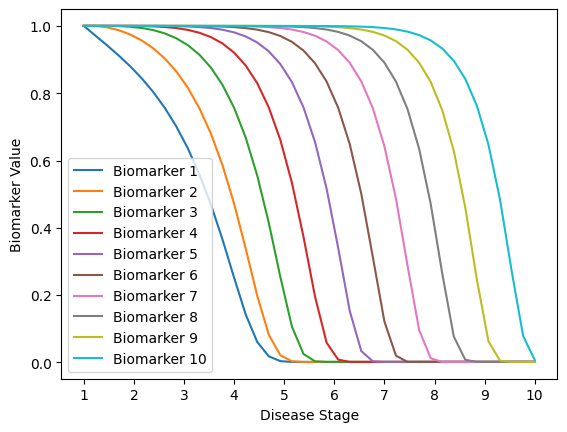

In [50]:
model_type = 'transition_matrix'
params = {
    'coeff': 1.45e-1
}

model = CanonicalGenerator(n_biomarker_stages=10,
                           model_type=model_type,
                           biomarkers_params=params,
                           random_state=10)

model.plot_disease_progression()
stage_values = model.get_stage_values()

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':3, 'scale':4, 'random_state':10},
                         add_noise=True,
                         noise_std=0.7,
                         random_state=2)

In [51]:
X = sample.get_X()
y = sample.get_y()

#run_multiple_ebm(X=X, y=y, csv_filename="transition_results.csv");

prior = model.get_prior()
run_multiple_ebm(X=X, y=y, prior=prior, csv_filename="transition_results_prior.csv");

100%|██████████| 500000/500000 [02:39<00:00, 3135.80it/s]


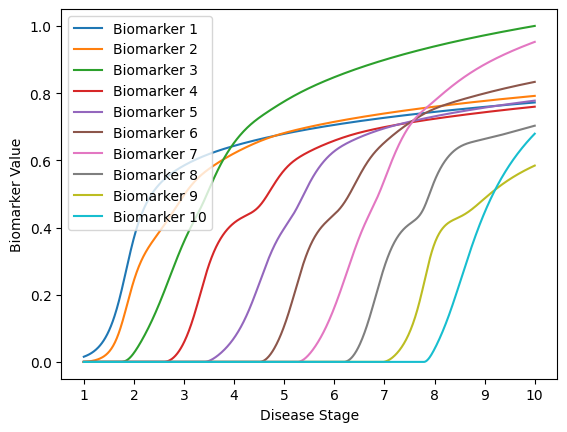

In [64]:
model_type = 'acp'

model = CanonicalGenerator(n_biomarker_stages=10,
                           model_type=model_type,
                           biomarkers_params=params,
                           random_state=10)

model.plot_disease_progression()
stage_values = model.get_stage_values()

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':3, 'scale':4, 'random_state':10},
                         add_noise=True,
                         noise_std=0.7,
                         random_state=2)